In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import missingno as msno
pd.options.mode.chained_assignment = None

import xgboost as xgb
from sklearn import model_selection, preprocessing

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
color = sn.color_palette()

## Data Analysis

In [2]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")
macro = pd.read_csv("datasets/macro.csv")

In [3]:
train.dtypes.value_counts()

int64      157
float64    119
object      16
dtype: int64

In [4]:
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,157
1,float64,119
2,object,16


C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


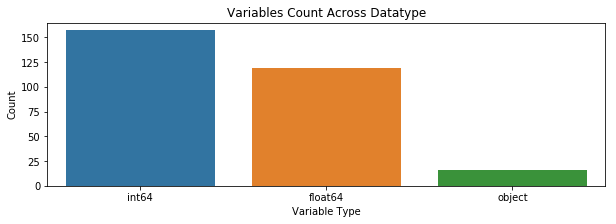

In [5]:
dataTypeDf = pd.DataFrame(train.dtypes.value_counts()).reset_index() \
                            .rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(10,3)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

###  1. Missing Values

[Missingno][Missingno] is a great package to quickly display missing values in a dataset. 

[Missingno]:https://datascientistnotebook.com/2017/05/23/handling-missing-data/

In [6]:
missingValueColumns = train.columns[train.isnull().any()].tolist()
missingValueColumns

['life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'preschool_quota',
 'school_quota',
 'hospital_beds_raion',
 'raion_build_count_with_material_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995',
 'metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'ID_railroad_station_walk',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_su

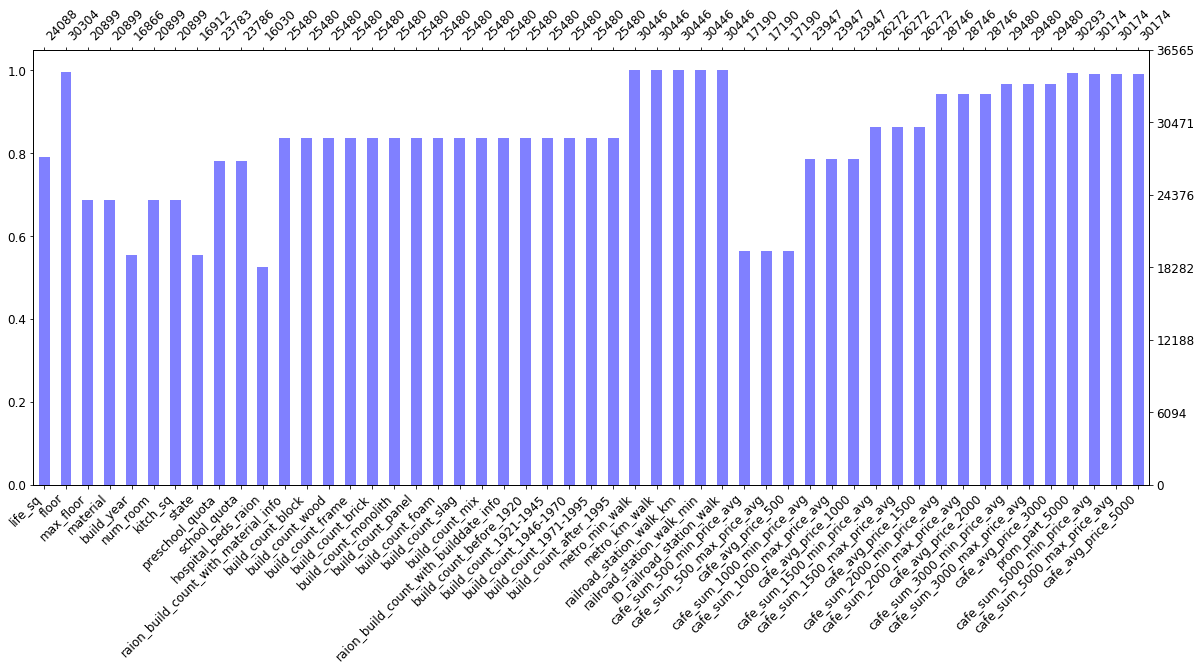

In [7]:
msno.bar(train[missingValueColumns], figsize=(20,8),color=(0.5, 0.5, 1),fontsize=12,labels=True,)

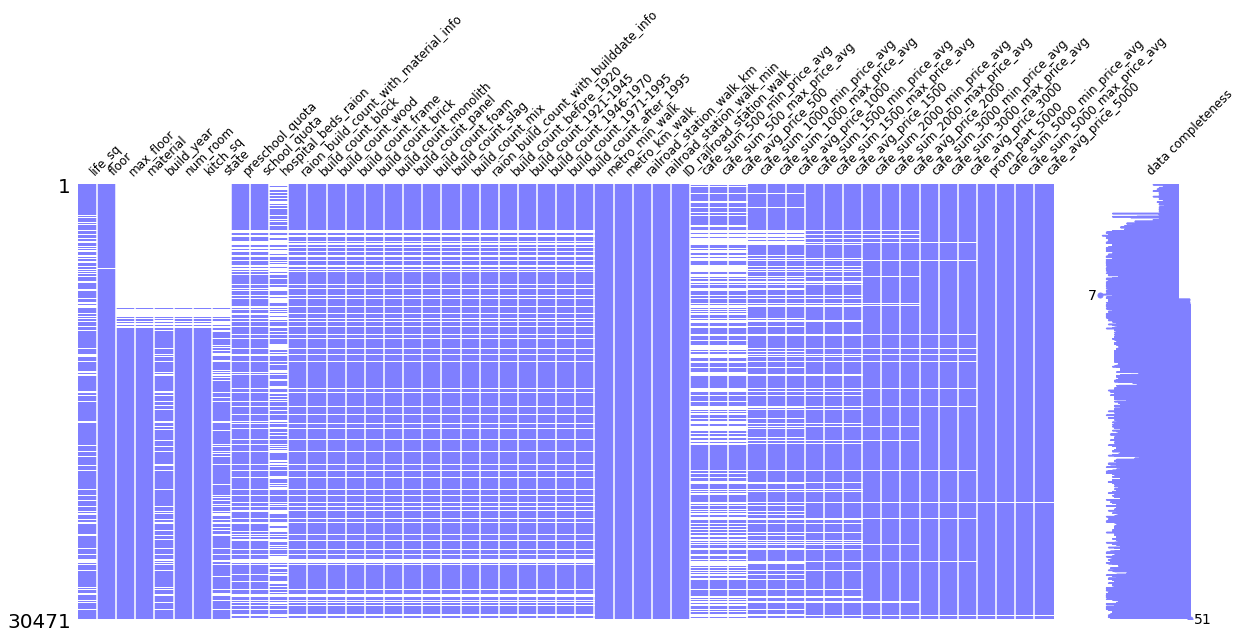

In [8]:
msno.matrix(train[missingValueColumns],width_ratios=(10,1),\
            figsize=(20,8),color=(0.5, 0.5, 1),fontsize=12,sparkline=True,labels=True)

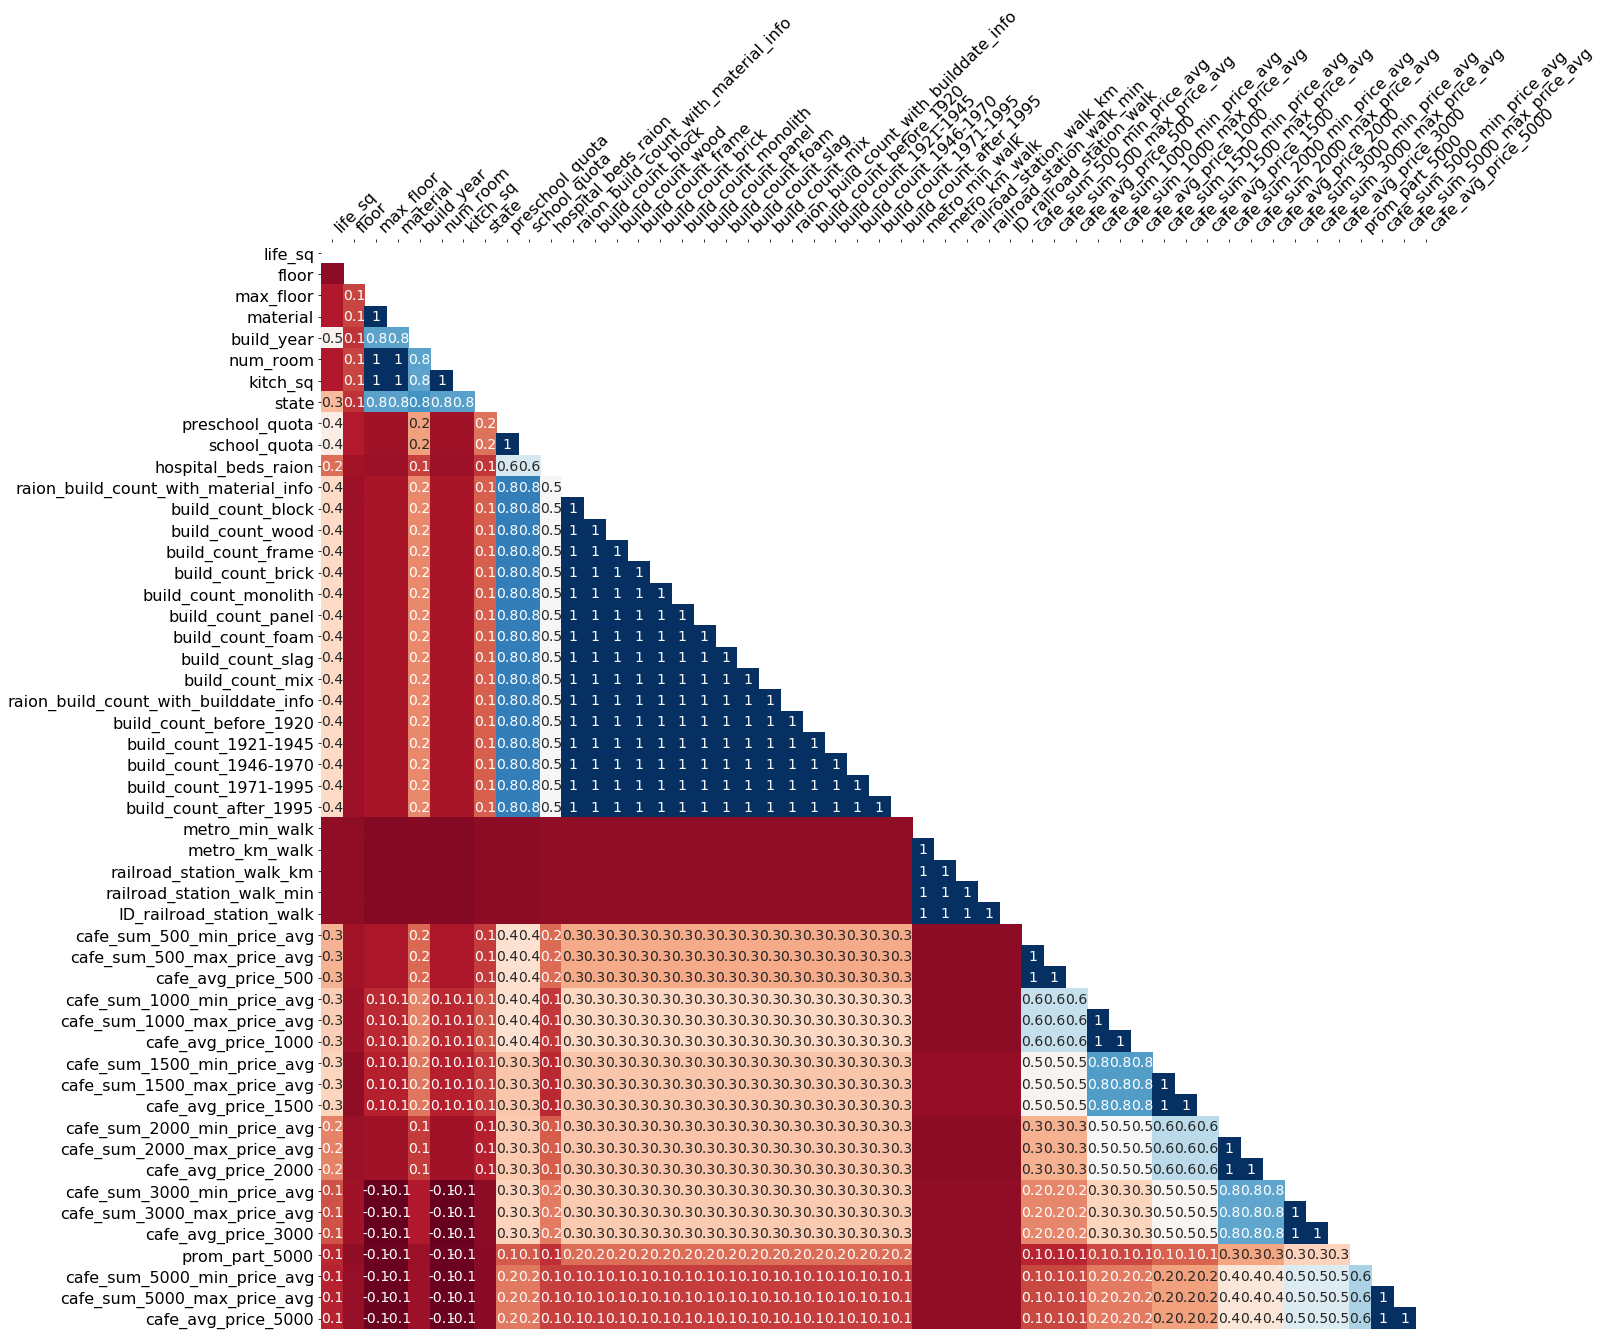

In [9]:
msno.heatmap(train[missingValueColumns],figsize=(20,20))

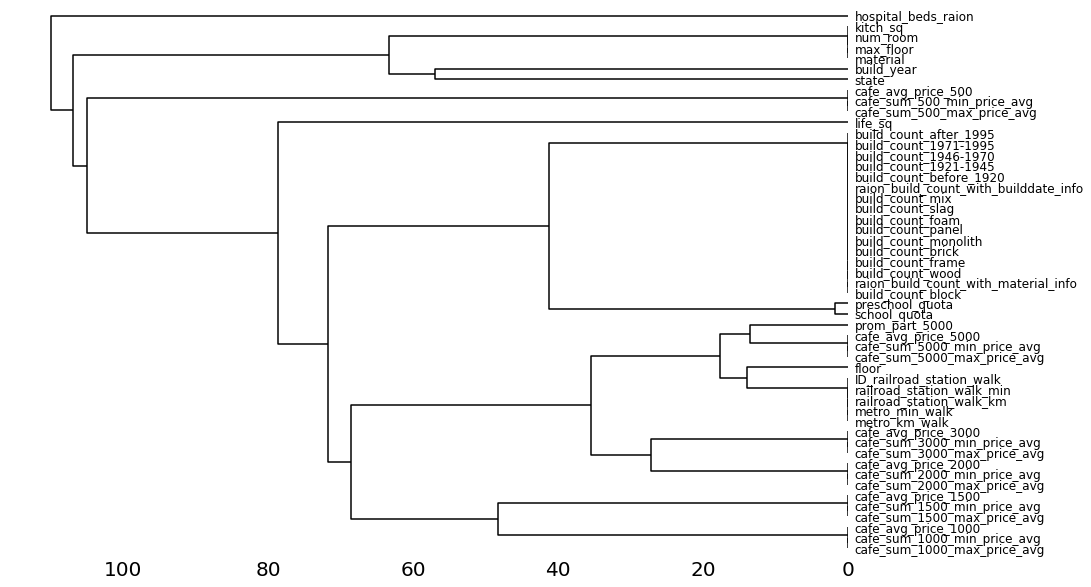

In [10]:
msno.dendrogram(train[missingValueColumns],figsize=(15,10),fontsize=12)

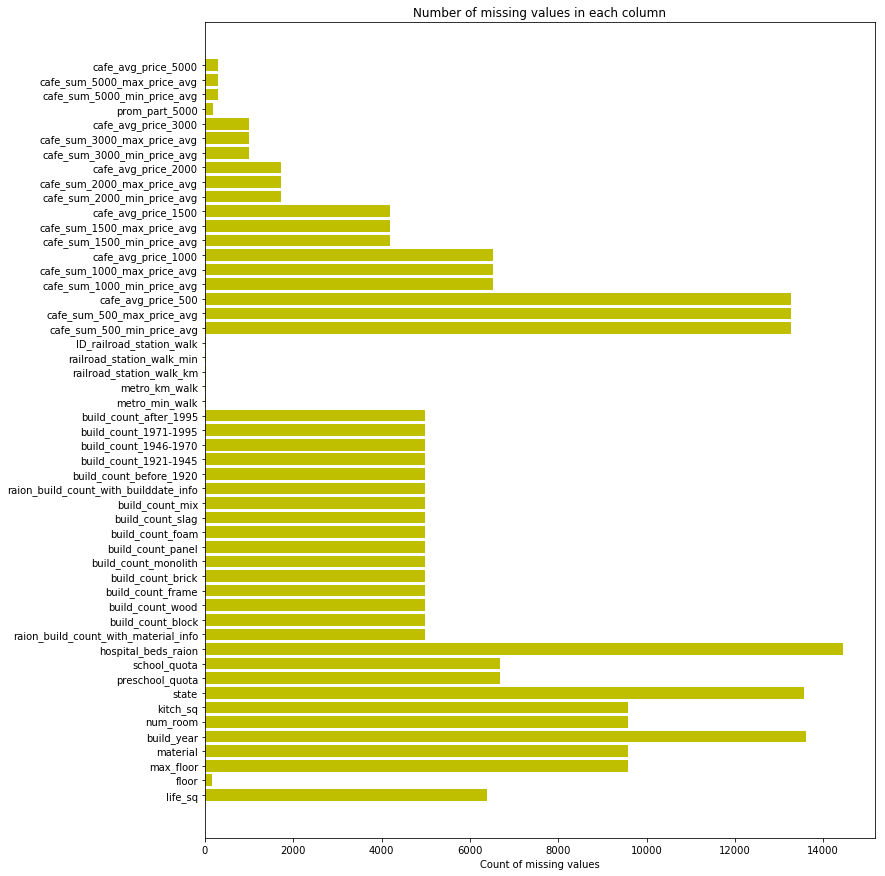

In [11]:
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9

fig, ax = plt.subplots(figsize=(12,15))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

### 2. Feature Engineering

#### $\star$ Price Doc 

First let us do a scatter plot to see if there are any outliers in the data.

((array([-4.07764062, -3.86644899, -3.75109077, ...,  3.75109077,
          3.86644899,  4.07764062]),
  array([ 11.51293546,  12.15478461,  12.20607765, ...,  18.32709614,
          18.37067606,  18.52604128])),
 (0.58651573976941307, 15.609483171522076, 0.97001952755917309))

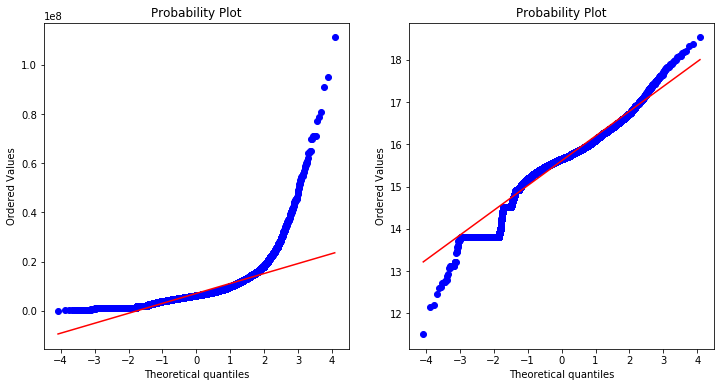

In [12]:
fig,axes = plt.subplots(ncols=2)
fig.set_size_inches(12, 6)
stats.probplot(train["price_doc"], dist='norm', fit=True, plot=axes[0])
stats.probplot(np.log1p(train["price_doc"]), dist='norm', fit=True, plot=axes[1])

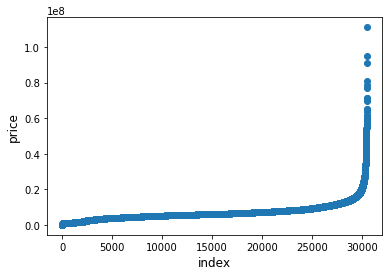

In [13]:
plt.figure(figsize=(6,4))
plt.scatter(range(train.shape[0]), np.sort(train.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

Since the metric is RMSLE (Root Mean Square Logarithmic Error), it is okay to have it as such. However if needed, one can truncate the high values. We can now bin the 'price_doc' and plot it.

C:\Users\dcjong\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


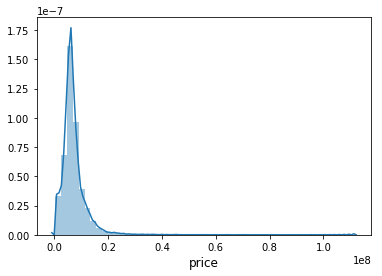

In [14]:
plt.figure(figsize=(6,4))
sn.distplot(train.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

There is a very long right tail. Since our metric is RMSLE, let us try to plot the log of price_doc variable.

C:\Users\dcjong\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


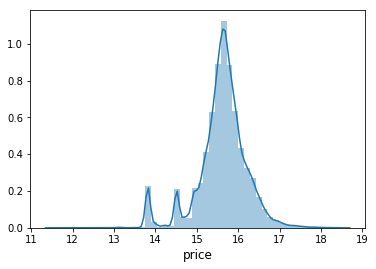

In [15]:
plt.figure(figsize=(6,4))
sn.distplot(np.log(train.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

This looks much better than the previous one.

#### $\star$ TimeStamp

Now let us see how the median housing price change with time. 

In [16]:
train['timestamp'].head()

0    2011-08-20
1    2011-08-23
2    2011-08-27
3    2011-09-01
4    2011-09-05
Name: timestamp, dtype: object

In [17]:
train['yearmonth'] = train['timestamp'].apply(lambda x: x[:4] + "-" + x[5:7])
train['year'] = train['timestamp'].apply(lambda x: x[:4])
train['month'] = train['timestamp'].apply(lambda x: x[5:7])

In [18]:
grouped = train.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()
grouped.head()

,yearmonth,price_doc
0,2011-08,5850000.0
1,2011-09,5200000.0
2,2011-10,5500000.0
3,2011-11,5600000.0
4,2011-12,5450000.0


C:\Users\dcjong\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


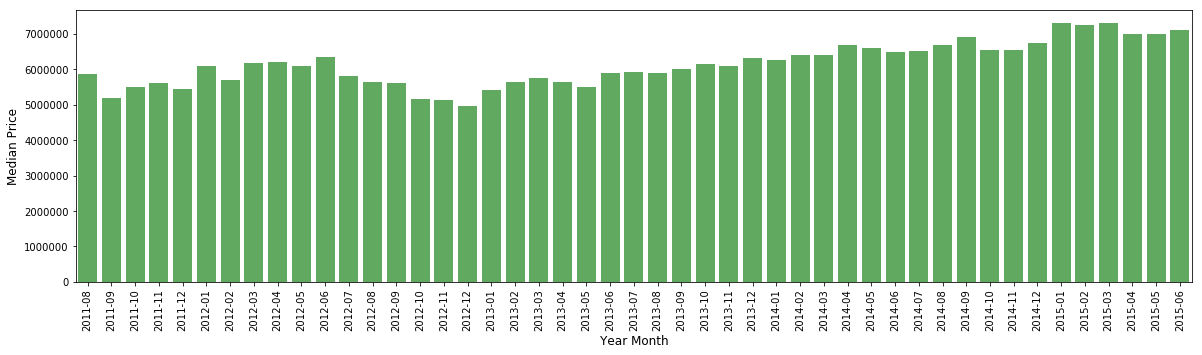

In [19]:
plt.figure(figsize=(20,5))
sn.barplot(grouped.yearmonth.values, grouped.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

There are some variations in the median price with respect to time. Towards the end, there seems to be some linear increase in the price values.

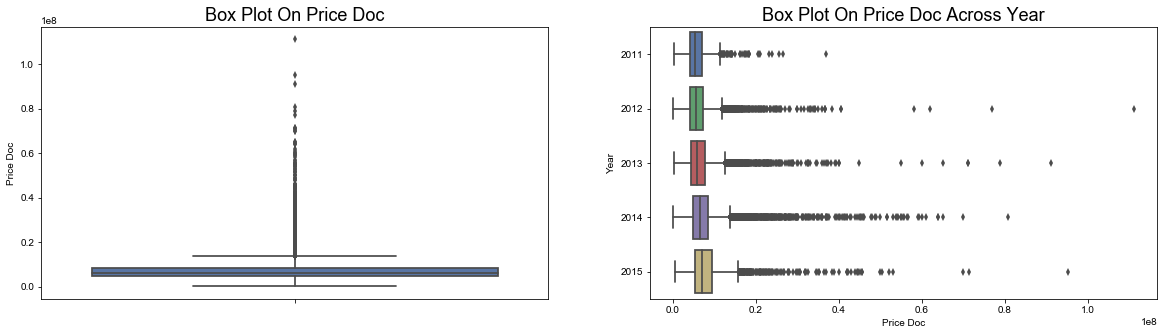

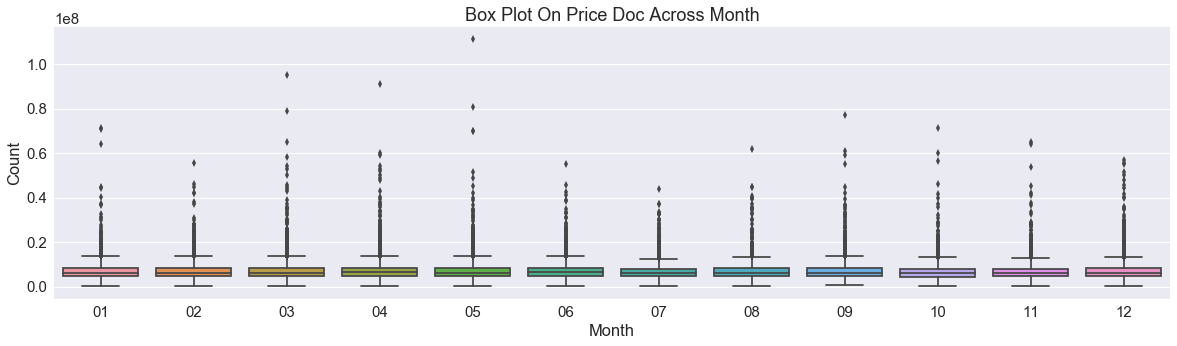

In [20]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.set(font_scale=1.5)
sn.boxplot(data=train,y="price_doc",orient="v",ax=ax1)
sn.boxplot(data=train,x="price_doc",y="year",orient="h",ax=ax2)

fig1,ax3 = plt.subplots()
fig1.set_size_inches(20,5)
sn.boxplot(data=train,x="month",y="price_doc",orient="v",ax=ax3)
ax1.set(ylabel='Price Doc',title="Box Plot On Price Doc")
ax2.set(xlabel='Price Doc', ylabel='Year',title="Box Plot On Price Doc Across Year")
ax3.set(xlabel='Month', ylabel='Count',title="Box Plot On Price Doc Across Month")

#### $\star$ Build Year

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

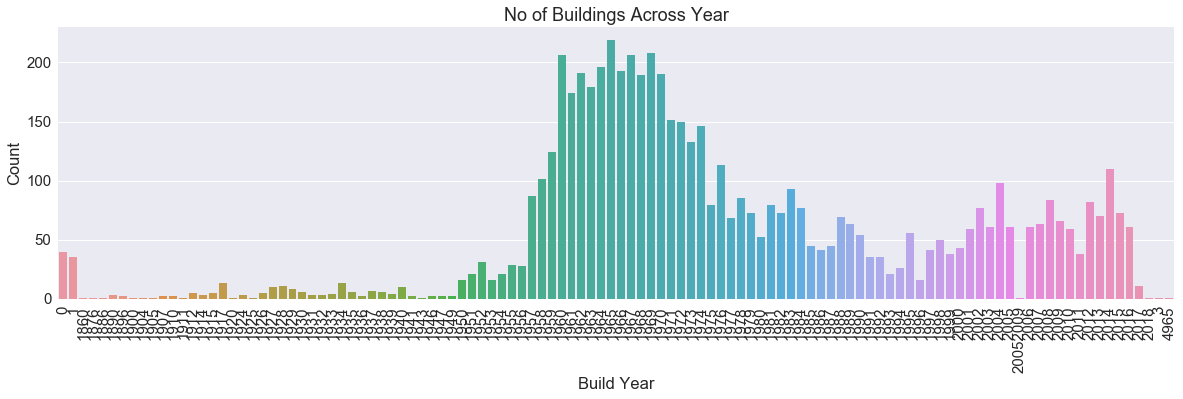

In [21]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
trainBuild = train.dropna()
trainBuild["yearbuilt"] = trainBuild["build_year"].map(lambda x:str(x).split(".")[0])
sn.countplot(data=trainBuild,x="yearbuilt",ax=ax)
ax.set(xlabel='Build Year', ylabel='Count',title="No of Buildings Across Year",label='big')
plt.xticks(rotation=90)

## Model Building

This version adjusts results using average predicted prices from a macro model.

I'm not sure I've succeeded in doing better than magic numbers, because I have a new trick now:

    y_rescaled = m  +  (y-ybar) * (1+ybar-m)

(everything in logs).  `m` is the new mean, which comes from the macro model, and the `1+ybar-m` is meant to offset the scale effect of the mean shift.  (The mean shift has a scale effect because we're working in logs, and shifting the mean of the log shifts both the mean and the scale of the raw numbers.  We wanted to shift the mean but not necessarily the scale.)  As far as calculation goes, it was the simplest way I could think to offset the scale effect, but it doesn't have a clear analytical meaning, and I wouldn't be doing it if it didn't improve the results.  But at least it doesn't involve any magic numbers.

There is also a provision for applying micro and macro humility factors . The micro humility factor adjusts individual predictions toward the mean.   (It applies to the second term in the rescaling shown above.)  The combination of the macro adjustment and the micro humility factor is equivalent to scaling down and adding a constant, which is what the magic numbers used to do.

There is also a macro humility factor. The macro humility factor adjusts the macro predictions by averaging in a "naive" macro model. That gives enough degrees of freedom to get back the effect of the magic numbers, but the new magic numbers will be humility parameters instead of just numbers that make the public leaderboard score higher. Of course I will adjust the humility parameters to maximize the public leaderboard score, but now with a stronger theoretical justification. (This amounts to using the public test cases as a cross-validation set, which is not unreasonable.)

Also, setting humility parameters, while having an *actual* macro model, means that the overall model can be used to predict the future beyond May 2016. Because there's a macro model, that model would be re-fit and used to predict future means, and the same humility parameters (or new ones, if one decides to change them based on private leaderboard performance) can be applied. You'll get actual predictions instead of the nonsense you would get by applying an arbitrary linear transformation that just happened to work well for the original test period.

In [22]:
# Parameters
micro_humility_factor = 1     #    range from 0 (complete humility) to 1 (no humility)
macro_humility_factor = 0.96
model_output_1_weight = .5
model_output_2_weight = 1 - model_output_1_weight

### 1. Macro Model

In [23]:
# Macro data monthly medians
macro["timestamp"] = pd.to_datetime(macro["timestamp"])
macro["year"]  = macro["timestamp"].dt.year
macro["month"] = macro["timestamp"].dt.month
macro["yearmonth"] = 100*macro.year + macro.month
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm,year,month,yearmonth
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,1,201001
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,1,201001
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,1,201001
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,1,201001
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,1,201001


In [24]:
macmeds = macro.groupby("yearmonth").median()
macmeds.head()

,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,...,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm,year,month
yearmonth,,,,,,,,,,,,,,,,,,,,,
201001,76.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.77500,42.5601,...,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,1
201002,72.97,NaN,NaN,315.1,337.2,NaN,18.114,NaN,30.11925,41.1596,...,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,2
201003,77.03,NaN,NaN,317.7,343.9,NaN,16.704,NaN,29.52680,40.2498,...,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,3
201004,82.87,9995.8,4.1,319.8,350.2,NaN,16.604,14.1,29.15250,39.2524,...,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,4
201005,73.05,9995.8,4.1,320.7,361.3,NaN,15.654,14.1,30.61500,38.4608,...,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,5


In [25]:
# Price data monthly medians
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["year"]  = train["timestamp"].dt.year
train["month"] = train["timestamp"].dt.month
train["yearmonth"] = 100*train.year + train.month

prices = train[["yearmonth","price_doc"]]
p = prices.groupby("yearmonth").median()
p.head()

,price_doc
yearmonth,
201108,5850000.0
201109,5200000.0
201110,5500000.0
201111,5600000.0
201112,5450000.0


In [26]:
# Join monthly prices to macro data
df = macmeds.join(p)
df.head()

,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,...,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm,year,month,price_doc
yearmonth,,,,,,,,,,,,,,,,,,,,,
201001,76.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.77500,42.5601,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,1,NaN
201002,72.97,NaN,NaN,315.1,337.2,NaN,18.114,NaN,30.11925,41.1596,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,2,NaN
201003,77.03,NaN,NaN,317.7,343.9,NaN,16.704,NaN,29.52680,40.2498,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,3,NaN
201004,82.87,9995.8,4.1,319.8,350.2,NaN,16.604,14.1,29.15250,39.2524,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,4,NaN
201005,73.05,9995.8,4.1,320.7,361.3,NaN,15.654,14.1,30.61500,38.4608,...,0.41,993.0,NaN,NaN,63.03,22825.0,NaN,2010,5,NaN


In [27]:
# Function to process Almon lags

import numpy.matlib as ml
 
def almonZmatrix(X, maxlag, maxdeg):
    """
    Creates the Z matrix corresponding to vector X.
    """
    n = len(X)
    Z = ml.zeros((len(X)-maxlag, maxdeg+1))
    for t in range(maxlag,  n):
        #Solve for Z[t][0].
        Z[t-maxlag,0] = sum([X[t-lag] for lag in range(maxlag+1)])
        for j in range(1, maxdeg+1):
            s = 0.0
            for i in range(1, maxlag+1):       
                s += (i)**j * X[t-i]
            Z[t-maxlag,j] = s
    return Z

In [28]:
# Prepare data for macro model
y = df.price_doc.div(df.cpi).apply(np.log).loc[201108:201506]
y.head()

yearmonth
201108    9.712655
201109    9.597135
201110    9.653791
201111    9.667005
201112    9.635634
dtype: float64

In [29]:
lncpi = df.cpi.apply(np.log)
lncpi.head()

yearmonth
201001         NaN
201002    5.752890
201003    5.761108
201004    5.767696
201005    5.770506
Name: cpi, dtype: float64

In [30]:
tblags = 5    # Number of lags used on PDL for Trade Balance
mrlags = 5    # Number of lags used on PDL for Mortgage Rate
cplags = 5    # Number of lags used on PDL for CPI
ztb = almonZmatrix(df.balance_trade.loc[201103:201506].as_matrix(), tblags, 1)
zmr = almonZmatrix(df.mortgage_rate.loc[201103:201506].as_matrix(), mrlags, 1)
zcp = almonZmatrix(lncpi.loc[201103:201506].as_matrix(), cplags, 1)

In [31]:
columns = ['tb0', 'tb1', 'mr0', 'mr1', 'cp0', 'cp1']
z = pd.DataFrame( np.concatenate( (ztb, zmr, zcp), axis=1), y.index.values, columns )
z.head()

,tb0,tb1,mr0,mr1,cp0,cp1
201108,104.098,268.575,73.01,184.40,35.177686,87.881303
201109,101.103,262.387,72.50,182.83,35.192806,87.947499
201110,101.265,261.268,71.70,181.11,35.201341,87.992705
201111,99.624,246.913,71.32,180.09,35.210403,88.020788
201112,101.929,245.971,70.56,178.45,35.218861,88.028984


In [32]:
X = sm.add_constant( z )
X.head()

,const,tb0,tb1,mr0,mr1,cp0,cp1
201108,1.0,104.098,268.575,73.01,184.40,35.177686,87.881303
201109,1.0,101.103,262.387,72.50,182.83,35.192806,87.947499
201110,1.0,101.265,261.268,71.70,181.11,35.201341,87.992705
201111,1.0,99.624,246.913,71.32,180.09,35.210403,88.020788
201112,1.0,101.929,245.971,70.56,178.45,35.218861,88.028984


In [33]:
# Fit macro model
eq = sm.OLS(y, X)
fit = eq.fit()

In [34]:
# Predict with macro model
test_cpi = df.cpi.loc[201507:201605]
test_index = test_cpi.index

ztb_test = almonZmatrix(df.balance_trade.loc[201502:201605].as_matrix(), tblags, 1)
zmr_test = almonZmatrix(df.mortgage_rate.loc[201502:201605].as_matrix(), mrlags, 1)
zcp_test = almonZmatrix(lncpi.loc[201502:201605].as_matrix(), cplags, 1)

z_test = pd.DataFrame( np.concatenate( (ztb_test, zmr_test, zcp_test), axis=1), test_index, columns )
X_test = sm.add_constant( z_test )

pred_lnrp = fit.predict( X_test )

In [35]:
pred_p = np.exp(pred_lnrp) * test_cpi
pred_p.head()

yearmonth
201507    6.792556e+06
201508    6.661121e+06
201509    6.600294e+06
201510    6.524351e+06
201511    6.526574e+06
dtype: float64

In [36]:
# Merge with test cases and compute mean for macro prediction
test["timestamp"] = pd.to_datetime(test["timestamp"])
test["year"]  = test["timestamp"].dt.year
test["month"] = test["timestamp"].dt.month
test["yearmonth"] = 100*test.year + test.month
test_ids = test[["yearmonth","id"]]

In [37]:
monthprices = pd.DataFrame({"yearmonth":pred_p.index.values,"monthprice":pred_p.values})
monthprices.head()

,monthprice,yearmonth
0,6.792556e+06,201507
1,6.661121e+06,201508
2,6.600294e+06,201509
3,6.524351e+06,201510
4,6.526574e+06,201511


In [38]:
macro_mean = np.exp(test_ids.merge(monthprices, on="yearmonth").monthprice.apply(np.log).mean())
macro_mean

6593788.9177276166

In [39]:
# Naive macro model assumes housing prices will simply follow CPI
naive_pred_lnrp = y.mean()
naive_pred_p = np.exp(naive_pred_lnrp) * test_cpi
monthnaive = pd.DataFrame({"yearmonth":pred_p.index.values, "monthprice":naive_pred_p.values})
macro_naive = np.exp(test_ids.merge(monthnaive, on="yearmonth").monthprice.apply(np.log).mean())
macro_naive

7773440.7512487005

In [40]:
# Combine naive and substantive macro models
macro_mean = macro_naive * (macro_mean/macro_naive) ** macro_humility_factor
macro_mean

6637341.6089051645

### 2. Micro Model

In [41]:
#clean data

train.drop(train[train["life_sq"] > 7000].index, inplace=True)

bad_index = train[train.life_sq > train.full_sq].index
train.loc[bad_index, "life_sq"] = np.NaN

equal_index = [601,1896,2791]
test.loc[equal_index, "life_sq"] = test.loc[equal_index, "full_sq"]

bad_index = test[test.life_sq > test.full_sq].index
test.loc[bad_index, "life_sq"] = np.NaN

bad_index = train[train.life_sq < 5].index
train.loc[bad_index, "life_sq"] = np.NaN

bad_index = test[test.life_sq < 5].index
test.loc[bad_index, "life_sq"] = np.NaN

bad_index = train[train.full_sq < 5].index
train.loc[bad_index, "full_sq"] = np.NaN

bad_index = test[test.full_sq < 5].index
test.loc[bad_index, "full_sq"] = np.NaN

kitch_is_build_year = [13117]
train.loc[kitch_is_build_year, "build_year"] = train.loc[kitch_is_build_year, "kitch_sq"]

bad_index = train[train.kitch_sq >= train.life_sq].index
train.loc[bad_index, "kitch_sq"] = np.NaN

bad_index = test[test.kitch_sq >= test.life_sq].index
test.loc[bad_index, "kitch_sq"] = np.NaN

bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.loc[bad_index, "kitch_sq"] = np.NaN

bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.loc[bad_index, "kitch_sq"] = np.NaN

bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.loc[bad_index, "full_sq"] = np.NaN

bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.loc[bad_index, "full_sq"] = np.NaN

bad_index = train[train.life_sq > 300].index
train.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN

bad_index = test[test.life_sq > 200].index
test.loc[bad_index, ["life_sq", "full_sq"]] = np.NaN

train.product_type.value_counts(normalize= True)
test.product_type.value_counts(normalize= True)

bad_index = train[train.build_year < 1500].index
train.loc[bad_index, "build_year"] = np.NaN

bad_index = test[test.build_year < 1500].index
test.loc[bad_index, "build_year"] = np.NaN

bad_index = train[train.num_room == 0].index 
train.loc[bad_index, "num_room"] = np.NaN

bad_index = test[test.num_room == 0].index 
test.loc[bad_index, "num_room"] = np.NaN

bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.loc[bad_index, "num_room"] = np.NaN

bad_index = [3174, 7313]
test.loc[bad_index, "num_room"] = np.NaN

bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.loc[bad_index, ["max_floor", "floor"]] = np.NaN

bad_index = train[train.floor == 0].index
train.loc[bad_index, "floor"] = np.NaN

bad_index = train[train.max_floor == 0].index
train.loc[bad_index, "max_floor"] = np.NaN

bad_index = test[test.max_floor == 0].index
test.loc[bad_index, "max_floor"] = np.NaN

bad_index = train[train.floor > train.max_floor].index
train.loc[bad_index, "max_floor"] = np.NaN

bad_index = test[test.floor > test.max_floor].index
test.loc[bad_index, "max_floor"] = np.NaN

train.floor.describe(percentiles= [0.9999])

bad_index = [23584]
train.loc[bad_index, "state"] = np.NaN
train.loc[bad_index, "floor"] = np.NaN

train.material.value_counts()
test.material.value_counts()
train.state.value_counts()

bad_index = train[train.state == 33].index
train.loc[bad_index, "state"] = np.NaN

In [42]:
# brings error down a lot by removing extreme price per sqm
train.loc[train.full_sq == 0, 'full_sq'] = 50
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

In [43]:
# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

In [44]:
# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

In [45]:
# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

In [46]:
# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

In [47]:
y_train = train["price_doc"]
wts = 1 - .47*(y_train == 1e6)
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

In [48]:
for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)  

In [49]:
num_train = len(x_train)
print('num_train shape is:', num_train)
num_val = int(num_train * 0.2)
print('num_val   shape is:', num_val)

num_train shape is: 30395
num_val   shape is: 6079


In [50]:
X_train = x_train[:-num_val]
X_val = x_train[-num_val:]

X_test = x_test

Y_train = y_train[:-num_val]
Y_val = y_train[-num_val:]

In [51]:
df_columns = x_train.columns

In [52]:
dtrain_all = xgb.DMatrix(x_train, y_train, feature_names=df_columns)
dtrain     = xgb.DMatrix(X_train, Y_train, feature_names=df_columns)
dval       = xgb.DMatrix(X_val, Y_val, feature_names=df_columns)
dtest      = xgb.DMatrix(X_test, feature_names=df_columns)

In [53]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [54]:
# Method for eatimate number of boost roots:

partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:9.19997e+06
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:4.81327e+06
[40]	val-rmse:3.47409e+06
[60]	val-rmse:3.05767e+06
[80]	val-rmse:2.90142e+06
[100]	val-rmse:2.83463e+06
[120]	val-rmse:2.79188e+06
[140]	val-rmse:2.75727e+06
[160]	val-rmse:2.7373e+06
[180]	val-rmse:2.72809e+06
[200]	val-rmse:2.72159e+06
[220]	val-rmse:2.70919e+06
[240]	val-rmse:2.69827e+06
[260]	val-rmse:2.68926e+06
[280]	val-rmse:2.6868e+06
[300]	val-rmse:2.68276e+06
[320]	val-rmse:2.67639e+06
[340]	val-rmse:2.67035e+06
[360]	val-rmse:2.66563e+06
[380]	val-rmse:2.66414e+06
[400]	val-rmse:2.66096e+06
[420]	val-rmse:2.6557e+06
[440]	val-rmse:2.65257e+06
[460]	val-rmse:2.65078e+06
[480]	val-rmse:2.65013e+06
[500]	val-rmse:2.64985e+06
[520]	val-rmse:2.64739e+06
[540]	val-rmse:2.64568e+06
[560]	val-rmse:2.64274e+06
[580]	val-rmse:2.64139e+06
[600]	val-rmse:2.64184e+06
Stopping. Best iteration:
[590]	val-rmse:2.63963e+06



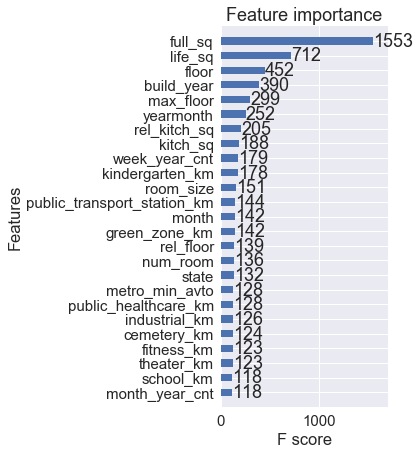

In [55]:
fig, ax = plt.subplots(figsize=(3,7))
xgb.plot_importance(partial_model, max_num_features=25, height=0.5, ax=ax)
plt.show()

In [56]:
num_boost_round = partial_model.best_iteration
print('num_boost_rounds:', num_boost_round )

num_boost_rounds: 590


In [57]:
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

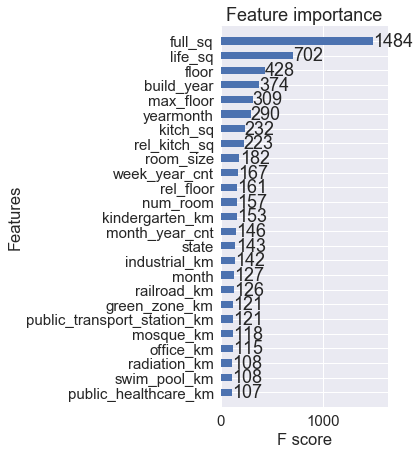

In [58]:
fig, ax = plt.subplots(figsize=(3, 7))
xgb.plot_importance(model, max_num_features=25, height=0.5, ax=ax)
plt.show()

In [59]:
id_test = test.id
y_predict = model.predict(dtest)
model_output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
model_output.head()
model_output.head()

,id,price_doc
0,30474,4862337.00
1,30475,7315656.50
2,30476,5154253.50
3,30477,5259373.50
4,30478,3983362.75


In [60]:
np.exp( model_output.price_doc.apply(np.log).mean() )

5891795.0635366486

### 3. Merge and Adjust the Results

In [61]:
# Merge

model_output_1 = model_output.copy() 
model_output_2 = model_output.copy() 
results = model_output_1.merge( model_output_2, on='id' , suffixes=['_1','_2'] )

results["price_doc"] = np.exp( np.log(results.price_doc_1)*model_output_1_weight +
                               np.log(results.price_doc_2)*model_output_2_weight )

results.drop(["price_doc_1", "price_doc_2"],axis=1,inplace=True)

results.head()

,id,price_doc
0,30474,4862337.5
1,30475,7315659.0
2,30476,5154253.0
3,30477,5259371.0
4,30478,3983361.5


In [62]:
# Adjust

lny = np.log(results.price_doc)
lnm = np.log(macro_mean)

# I'm not sure whether this makes any sense or not.
# 1+lny.mean()-lnm term is meant to offest the scale effect of the logarithmic mean shift
# while allowing the new logarithmic mean to remain at lnm.

y_trans = lnm  +  micro_humility_factor * (lny-lny.mean()) * (1+lny.mean()-lnm)
y_predict = np.exp( y_trans )

sub = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
sub.head()

,id,price_doc
0,30474,5604399.5
1,30475,8031546.5
2,30476,5899740.0
3,30477,6005600.0
4,30478,4701664.5


## Discussion and Conclusion

### 1. Multicollinearity Analysis and Variance Inflation Factor 

Most of the variables are highly collinear in nature. It is highly possbile to have multicollinearity problem in the dataset. For example variable such 0_13_all, 0_13_male, 0_13_female exhibit very collinearity. It is advisable to retain any one of them during model building. Since the following takes more than stipulated time. I have commented it out.

In [63]:
train = pd.read_csv("datasets/train.csv")
train['yearmonth'] = train['timestamp'].apply(lambda x: x[:4] + "-" + x[5:7])
train['year'] = train['timestamp'].apply(lambda x: x[:4])
train['month'] = train['timestamp'].apply(lambda x: x[5:7])

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

numericalCol = []
for f in train.columns:
    if train[f].dtype!='object':
        numericalCol.append(f)
        
trainNA = train[numericalCol].dropna() 
vifDict = calculate_vif_(trainNA)
vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=True,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

variablesWithMC.head()

,variables,vifScore
140,office_sqm_500,6.145365
158,sport_count_500,6.183117
138,prom_part_500,6.312055
182,market_count_1000,6.334231
225,mosque_count_2000,6.965763


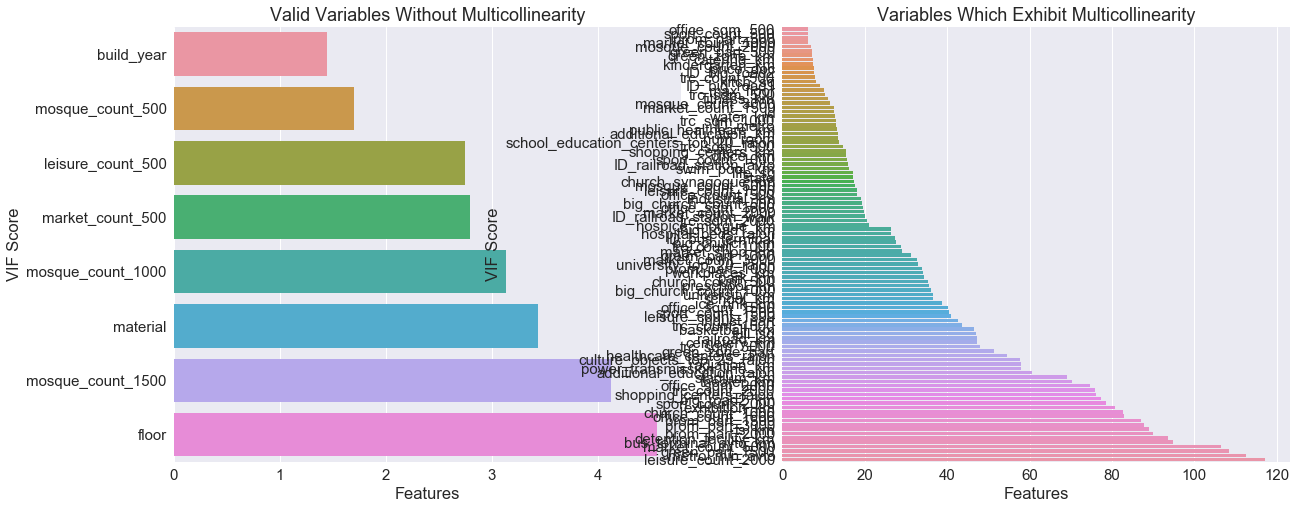

In [65]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sn.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h")
sn.barplot(data=variablesWithMC.head(100),x="vifScore",y="variables",ax=ax2,orient="h")
ax1.set(xlabel='Features', ylabel='VIF Score',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='Features', ylabel='VIF Score',title="Variables Which Exhibit Multicollinearity")

The folowing is based on the prior work done by [Roberto Ruiz][Roberto Ruiz]. Based on the work set out by Roberto, I've created a scikit-learn transformer class that can be used to remove columns that have a high VIF factor (in short, they have high colinearity with other columns within the dataset and as such should probably be removed).

This class is based on a standard scikit-learn transformer and also uses the statsmodel library for calculating the VIF number. Information on scikit-learn transformers can be found [here](http://scikit-learn.org/stable/data_transforms.html) whilst the docs for the statsmodel function can be found [here](http://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html).

[Roberto Ruiz]:https://www.kaggle.com/robertoruiz/sberbank-russian-housing-market/dealing-with-multicollinearity

In [66]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [67]:
#load files
train = pd.read_csv('datasets/train.csv', parse_dates=['timestamp'])
test = pd.read_csv('datasets/test.csv', parse_dates=['timestamp'])
macro = pd.read_csv('datasets/macro.csv', parse_dates=['timestamp'])

In [68]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print('Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [69]:
transformer = ReduceVIF()

x = train.copy()
y = x.pop('price_doc')

# Only use 10 columns for speed in this example
vif = transformer.fit_transform(x[x.columns[-10:]], y)

vif.head()

ReduceVIF fit
ReduceVIF transform
Dropping {X.columns[maxloc]} with vif={max_vif}
Dropping {X.columns[maxloc]} with vif={max_vif}
Dropping {X.columns[maxloc]} with vif={max_vif}
Dropping {X.columns[maxloc]} with vif={max_vif}
Dropping {X.columns[maxloc]} with vif={max_vif}
Dropping {X.columns[maxloc]} with vif={max_vif}
Dropping {X.columns[maxloc]} with vif={max_vif}


,cafe_count_5000_price_high,mosque_count_5000,market_count_5000
0,0.0,1.0,4.0
1,0.0,1.0,14.0
2,0.0,0.0,10.0
3,1.0,0.0,3.0
4,17.0,2.0,14.0


Things to bear in mind:

 - It's really slow, especially at the beginning when it's calculating VIF for all columns. As it drops more columns it will speed up, but there's a reason I've only used 10 columns for the example...
 - If two or more columns "tie" (in the case when multiple can be inf...) then it'll drop the first column it finds to start with.
 - The idea of imputing so much data makes me uneasy. I'd be tempted to modify it so you use the imputed data only for dropping columns but then continue analysis with all of the NaNs present.

### 2. Adversarial Validation

Like probably everyone else in this contest, I've been scratching my head: what to do about validation? The usual approaches don't work (obviously regular cross validation is a bad idea due to the time dimension, the score on last year of data is nowhere near the LB). Solution? [Adversarial validation][Adversarial validation], inspired by FastML.

The general idea is to check the degree of similarity between training and tests in terms of feature distribution: if they are difficult to distinguish, the distribution is probably similar and the usual validation techniques should work. It does not seem to be the case, so we can suspect they are quite different. This intuition can be quantified by combining train and test sets, assigning 0/1 labels (0 - train, 1-test) and evaluating a binary classification task.

[Adversarial validation]: http://fastml.com/adversarial-validation-part-two/

In [70]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [71]:
df_train = train.copy()
df_test = test.copy()

id_train = df_train['id']
time_train = df_train['timestamp']
y_train = df_train['price_doc']
df_train.drop(['id', 'timestamp', 'price_doc'], axis = 1, inplace = True)
df_train.fillna(-1, inplace = True)

id_test = df_test['id']            
time_test = df_test['timestamp']
df_test.drop(['id', 'timestamp'], axis = 1, inplace = True)

# add identifier and combine
df_train['istrain'] = 1
df_test['istrain'] = 0
df_all = pd.concat([df_train, df_test], axis = 0)

# convert non-numerical columns to integers
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()
    
for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]
    
df_all = pd.concat([df_numeric, df_obj], axis=1)
y = df_all['istrain'];df_all.drop('istrain', axis = 1, inplace = True)

In [72]:
# define a split and the model (xgboost, what else :-)

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 44)

xgb_params = {
        'learning_rate': 0.05, 'max_depth': 4,'subsample': 0.9,
        'colsample_bytree': 0.9,'objective': 'binary:logistic',
        'silent': 1, 'n_estimators':100, 'gamma':1,
        'min_child_weight':4
        }   

clf = xgb.XGBClassifier(**xgb_params, random_state = 10)    

[ROC][ROC] curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

[ROC]:https://www.medcalc.org/manual/roc-curves.php

1. [Introduction to ROC Curves](http://gim.unmc.edu/dxtests/ROC1.htm)
2. [Plotting and Intrepretating an ROC Curve](http://gim.unmc.edu/dxtests/roc2.htm)
3. [The Area Under an ROC Curve](http://gim.unmc.edu/dxtests/roc3.htm)

In [73]:
# calculate the ROC for each fold

for train_index, test_index in skf.split(df_all, y):
        x0, x1 = df_all.iloc[train_index], df_all.iloc[test_index]
        y0, y1 = y.iloc[train_index], y.iloc[test_index]        
        print('Shape:', x0.shape)
        clf.fit(x0, y0, eval_set=[(x1, y1)],
               eval_metric='logloss', verbose=False,early_stopping_rounds=10)
                
        prval = clf.predict_proba(x1)[:,1]
        print('ROC:  ', roc_auc_score(y1,prval))

Shape: (30505, 289)
ROC:   0.992518222298
Shape: (30506, 289)
ROC:   0.992994403187
Shape: (30507, 289)
ROC:   0.993578197448
Shape: (30507, 289)
ROC:   0.992616062454
Shape: (30507, 289)
ROC:   0.993526194493


As we can see, the separation is almost perfect - which strongly suggests that the train / test rows are very easy to distinguish even for an xgboost

### 3. Principal Component Analysis

In [74]:
def sel_grp(keys):
    lst_all = list()
    for k in keys:
        lst = [c for c in alldata.columns if c.find(k)!=-1 and c not in excl_col and c not in resv_col]
        lst = list(set(lst))
        lst_all += lst
    return(lst_all)

In [75]:
alldata = pd.concat([train, test],ignore_index=True)

macro.columns = ['mac__'+c if c!='timestamp' else 'timestamp' for c in macro.columns ]
alldata=alldata.merge(macro,on='timestamp',how='left')

excl_col = ['id','timestamp','sub_area'] + [c for c in alldata.columns if alldata[c].dtype=='object']
resv_col = ['price_doc','LogAmt','Source','cafe_sum_500_max_price_avg','cafe_sum_500_min_price_avg',
           'cafe_avg_price_500','hospital_beds_raion']

In [76]:
col_grp = dict({})
col_grp['people']=sel_grp(['_all','male'])
col_grp['id'] = sel_grp(['ID_'])
col_grp['church']=sel_grp(['church'])
col_grp['build']=sel_grp(['build_count_'])
col_grp['cafe']=sel_grp(['cafe_count'])
col_grp['cafeprice']=sel_grp(['cafe_sum','cafe_avg'])
col_grp['km']=sel_grp(['_km','metro_min','_avto_min','_walk_min','_min_walk'])
col_grp['mosque']=sel_grp(['mosque_count'])
col_grp['market']=sel_grp(['market_count'])
col_grp['office']=sel_grp(['office_count'])
col_grp['leisure']=sel_grp(['leisure_count'])
col_grp['sport']=sel_grp(['sport_count'])
col_grp['green']=sel_grp(['green_part'])
col_grp['prom']=sel_grp(['prom_part'])
col_grp['trc']=sel_grp(['trc_count'])
col_grp['sqm']=sel_grp(['_sqm_'])
col_grp['raion']=sel_grp(['_raion'])
col_grp['macro']=sel_grp(['mac__'])
col_grp.keys()
loopkeys=list(col_grp.keys())
print(loopkeys)

['people', 'id', 'church', 'build', 'cafe', 'cafeprice', 'km', 'mosque', 'market', 'office', 'leisure', 'sport', 'green', 'prom', 'trc', 'sqm', 'raion', 'macro']


In [77]:
col_tmp = list()

for d in col_grp:
    col_tmp+=(col_grp[d])
    
col_grp['other']=[c for c in alldata.columns if c not in col_tmp and c not in excl_col and c not in resv_col]
col_grp['other']  ## these 'other' variables are not to be PCA

['area_m',
 'build_year',
 'children_preschool',
 'children_school',
 'floor',
 'full_sq',
 'green_zone_part',
 'indust_part',
 'kitch_sq',
 'life_sq',
 'material',
 'max_floor',
 'num_room',
 'preschool_quota',
 'raion_popul',
 'school_quota',
 'state']

In [78]:
## remove variables in macro data with too many missing data

macro_missing_2 = pd.DataFrame([[c,sum(alldata[c].isnull())] for c in col_grp['macro']],columns=['Var','Missing'])
macro_missing_3 = macro_missing_2[macro_missing_2.Missing>5000]
print(macro_missing_3)

                                            Var  Missing
3               mac__provision_retail_space_sqm    32541
5               mac__unprofitable_enterpr_share    10901
8                        mac__water_pipes_share    10901
11               mac__students_reg_sports_share    24563
12                        mac__housing_fund_sqm    10901
15         mac__hospital_beds_available_per_cap    10901
17                         mac__old_house_share    10901
18                    mac__electric_stove_share    10901
24                      mac__share_own_revenues    10901
25             mac__population_reg_sports_share    10901
26           mac__theaters_viewers_per_1000_cap    24563
29                           mac__pop_migration    10901
32                  mac__marriages_per_1000_cap    10901
33       mac__provision_retail_space_modern_sqm    37380
34       mac__real_dispos_income_per_cap_growth    10901
38                             mac__baths_share    10901
39                          mac

In [79]:
excl_col+=list(macro_missing_3.Var)
print(excl_col)
col_grp['macro']=sel_grp(['mac__'])

['id', 'timestamp', 'sub_area', 'big_market_raion', 'big_road1_1line', 'culture_objects_top_25', 'detention_facility_raion', 'ecology', 'incineration_raion', 'nuclear_reactor_raion', 'oil_chemistry_raion', 'product_type', 'radiation_raion', 'railroad_1line', 'railroad_terminal_raion', 'sub_area', 'thermal_power_plant_raion', 'water_1line', 'mac__child_on_acc_pre_school', 'mac__modern_education_share', 'mac__old_education_build_share', 'mac__provision_retail_space_sqm', 'mac__unprofitable_enterpr_share', 'mac__water_pipes_share', 'mac__students_reg_sports_share', 'mac__housing_fund_sqm', 'mac__hospital_beds_available_per_cap', 'mac__old_house_share', 'mac__electric_stove_share', 'mac__share_own_revenues', 'mac__population_reg_sports_share', 'mac__theaters_viewers_per_1000_cap', 'mac__pop_migration', 'mac__marriages_per_1000_cap', 'mac__provision_retail_space_modern_sqm', 'mac__real_dispos_income_per_cap_growth', 'mac__baths_share', 'mac__sewerage_share', 'mac__hot_water_share', 'mac__po

In [80]:
def partial_pca(var,data,col_grp):
    from sklearn.decomposition import PCA
    import bisect
    pca = PCA()
    df = data[col_grp[var]].dropna()
    #print([len(data[col_grp[var]]), len(df)])
    df = (df-df.mean())/df.std(ddof=0)
    pca.fit(df)
    varexp = pca.explained_variance_ratio_.cumsum()
    cutoff = bisect.bisect(varexp, 0.95)
    print('cutoff:', cutoff)
    print('explained_variance_ratio:', pca.explained_variance_ratio_.cumsum())
    newcol=pd.DataFrame(pca.fit_transform(X=df)[:,0:(cutoff+1)],columns=['PCA_'+var+'_'+str(i) for i in range(cutoff+1)],index=df.index)
    #print(newcol)
    col_grp['PCA_'+var]=list(newcol.columns)
    return(newcol,col_grp,pca)

In [81]:
for c in loopkeys:
    if c!='other':
        print(c)
        newcol,col_grp,pca = partial_pca(c,alldata,col_grp)
        alldata=alldata.join(newcol)
        print(alldata.shape)

people
cutoff: 1
explained_variance_ratio: [ 0.75358221  0.96634078  0.99302882  0.99688305  0.99836134  0.99905957
  0.99940383  0.99972789  0.9998122   0.99987681  0.9999369   0.99998145
  0.99998845  0.99999331  0.99999768  0.99999875  0.99999963  1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.        ]
(38133, 393)
id
cutoff: 5
explained_variance_ratio: [ 0.32248953  0.51299739  0.66464892  0.78032815  0.88006169  0.95325455
  1.        ]
(38133, 399)
church
cutoff: 3
explained_variance_ratio: [ 0.80190373  0.90205669  0.94520849  0.9793058   0.98548582  0.99102094
  0.99375558  0.99602154  0.99755178  0.99860959  0.99912862  0.99962553
  0.99984399  1.        ]
(38133, 403)
build
cutoff: 6
explained_variance_ratio: [ 0.49372363  0.62561041  0.73996854  0.8155659   0.88130985  0.93485062
  0.95917782  0.97248552  0.98353837  0.99141242  0.99611081  0.9985657
  0.99999858  1.          1.          1.        ]
(38133, 410)
cafe
cutoff: 

### 4. Bivariate Analysis

The top 5 variables and their description from the data dictionary are:

 1. full_sq - total area in square meters, including loggias, balconies and other non-residential areas
 2. life_sq - living area in square meters, excluding loggias, balconies and other non-residential areas
 3. floor - for apartments, floor of the building
 4. max_floor - number of floors in the building
 5. build_year - year built

Now let us see how these important variables are distributed with respect to target variable.


In [82]:
for col in ["price_doc", "full_sq", "life_sq"]:
    ulimit = np.percentile(train[col].values, 99.5)
    llimit = np.percentile(train[col].values, 0.5)
    train[col].ix[train[col]>ulimit] = ulimit
    train[col].ix[train[col]<llimit] = llimit

#### $\star$ Full Square Vs. Price Doc

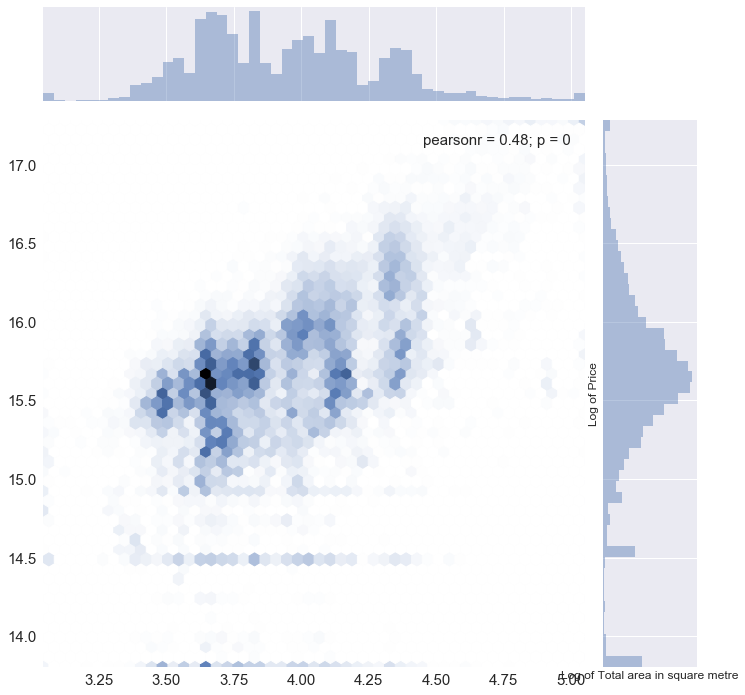

In [83]:
plt.figure(figsize=(12,12))
sn.jointplot(x=np.log1p(train.full_sq.values), y=np.log1p(train.price_doc.values), size=10,kind="hex")
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()

#### $\star$ Life Square Vs. Price Doc

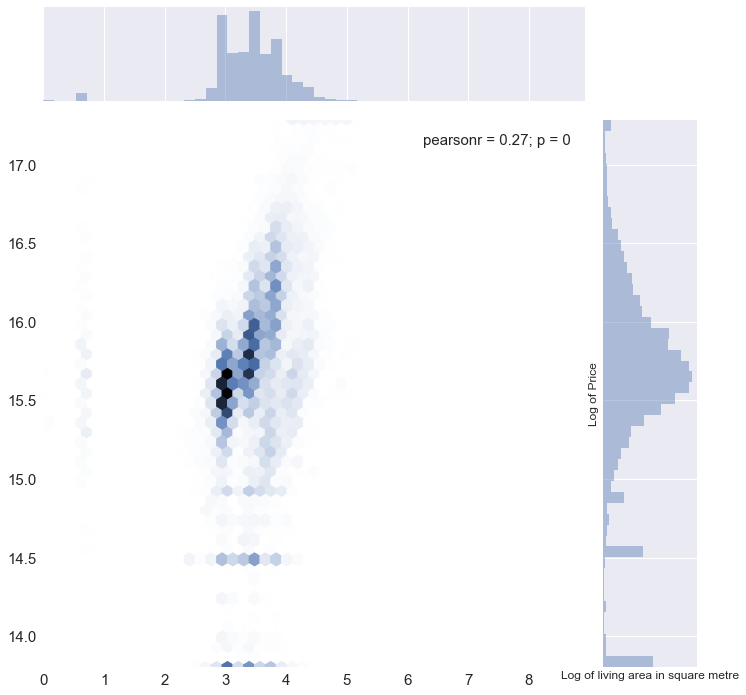

In [84]:
plt.figure(figsize=(12,12))
sn.jointplot(x=np.log1p(train.life_sq.values), y=np.log1p(train.price_doc.values), size=10,kind="hex")
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of living area in square metre', fontsize=12)
plt.show()

#### $\star$ Floor Vs. Price Doc

We will see the count plot of floor variable.

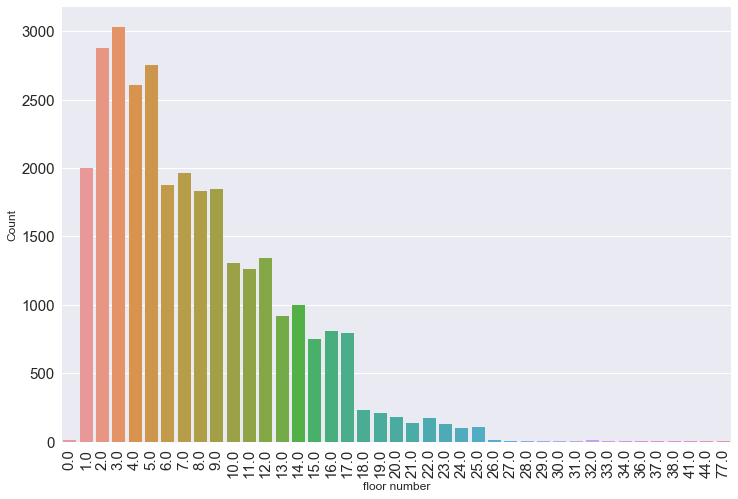

In [85]:
plt.figure(figsize=(12,8))
sn.countplot(x="floor", data=train)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The distribution is right skewed. There are some good drops in between (5 to 6, 9 to 10, 12 to 13, 17 to 18). Now let us see how the price changes with respect to floors.

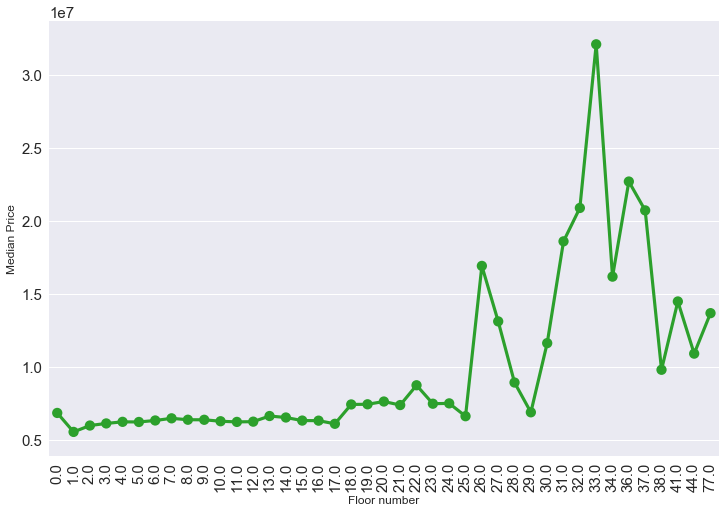

In [86]:
grouped = train.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sn.pointplot(grouped.floor.values, grouped.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

This shows an overall increasing trend (individual houses seems to be costlier as well - check price of 0 floor houses). 
A sudden increase in the house price is also observed at floor 18.

#### $\star$ Max Floor Vs. Price Doc

Total number of floors in the building is one another important variable. So let us plot that one and see.

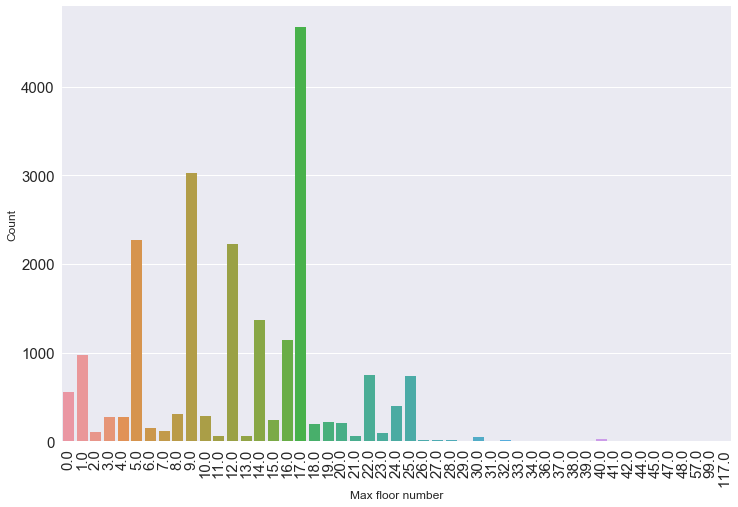

In [87]:
plt.figure(figsize=(12,8))
sn.countplot(x="max_floor", data=train)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Max floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We could see that there are few tall bars in between (at 5,9,12,17 - similar to drop in floors in the previous graph). May be there are some norms / restrictions on the number of maximum floors present(?). 

Now let us see how the median prices vary with the max floors. 

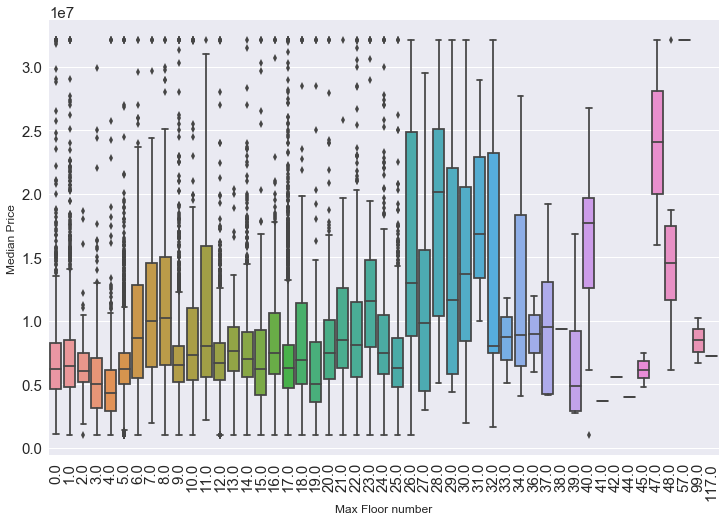

In [88]:
plt.figure(figsize=(12,8))
sn.boxplot(x="max_floor", y="price_doc", data=train)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### $\star$ Build Year Vs. Price Doc

(0, 70000000)

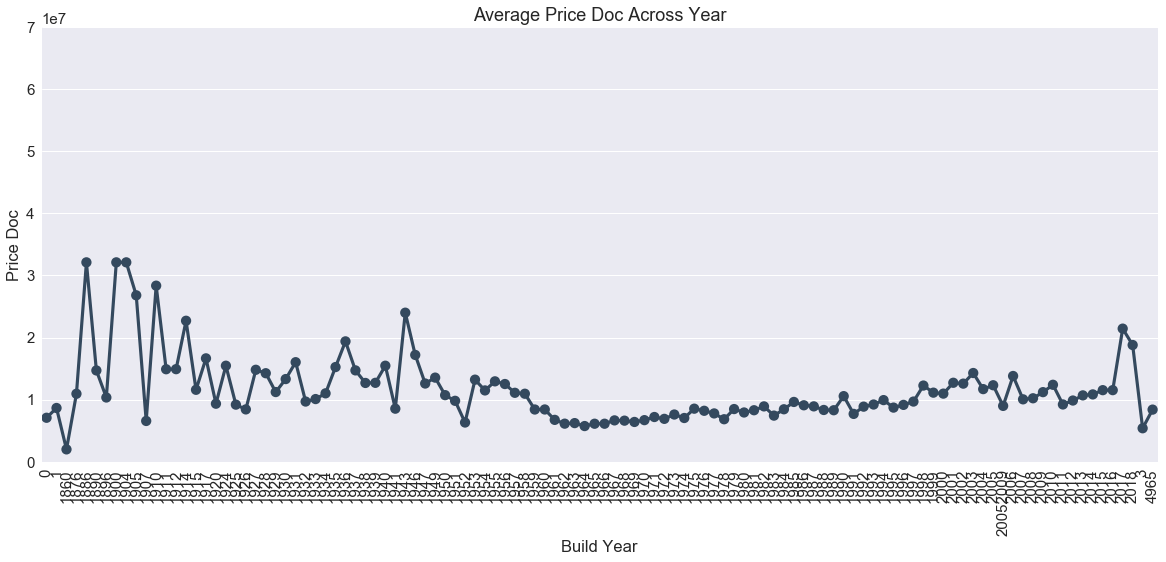

In [89]:
fig,ax= plt.subplots()
fig.set_size_inches(20,8)
trainBuild = train.dropna()
trainBuild["yearbuilt"] = trainBuild["build_year"].map(lambda x:str(x).split(".")[0])
trainBuildGrouped = trainBuild.groupby(["yearbuilt"])["price_doc"].mean().to_frame().reset_index()
sn.pointplot(x=trainBuildGrouped["yearbuilt"], y=trainBuildGrouped["price_doc"], data=trainBuildGrouped, join=True,ax=ax,color="#34495e")
ax.set(xlabel='Build Year', ylabel='Price Doc',title="Average Price Doc Across Year",label='big')
plt.xticks(rotation=90)
plt.ylim([0,70000000])